## Skin Cancer Detection using the FastAI library

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 64 # dependent on GPU in use

### Obtaining the Dataset
Uncomment and run this section after first downloading the repo to get the data.

In [4]:
from pathlib import Path

In [5]:
path = Path('./data')
path

PosixPath('data')

In [6]:
! #kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign -p "{path}"
! #unzip "{path}/skin-cancer-malignant-vs-benign.zip" -d "{path}"

Now have the data...

## Data Visualization

In [7]:
path_train = path/'train'
path_test = path/'test'
path_train

PosixPath('data/train')

The data is labeled by folder. That sounds like a standard case for Image Data bunch

In [8]:
(path/'train').ls()

[PosixPath('data/train/benign'), PosixPath('data/train/malignant')]

Need to change transforms for both data blocks:

In [9]:
tfms = get_transforms(flip_vert=True, max_warp=0.1)

Should we use the test set for validation?

In [10]:
data = ImageDataBunch.from_folder(path, train="/train", valid_pct=0.2,
                                  ds_tfms=tfms, size=224, bs=bs).normalize(imagenet_stats)

Need to set up a validation set using the Datablock api

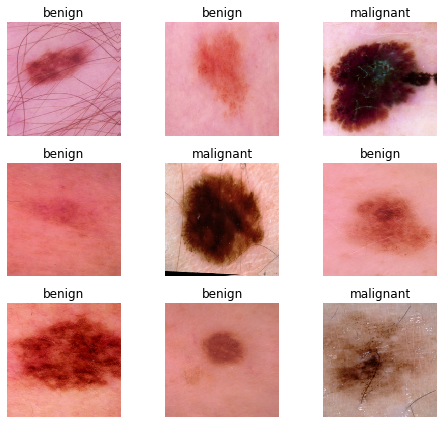

In [11]:
data.show_batch(rows=3,figsize=(7,6))

The images seems to be showing up pretty well. Size is already 224 by 224. All transforms seem to be valid, even lighting changes.

### Attempt using Resnet 34

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


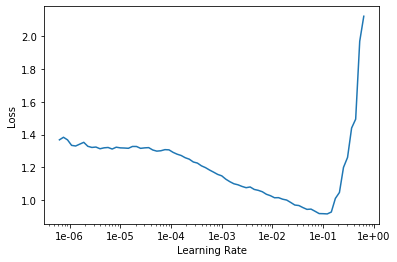

In [14]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(6, 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.547275,0.413933,0.147951,00:19
1,0.413339,0.320152,0.149469,00:18
2,0.304062,0.259914,0.135812,00:18
3,0.267607,0.203942,0.088012,00:18
4,0.212131,0.177236,0.074355,00:18
5,0.180564,0.168819,0.070561,00:18


got to like .13 with 1-e3, .10 with 1e-2

In [16]:
learn.save('stage-1-rn34')

### Model Fine-tuning

In [17]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


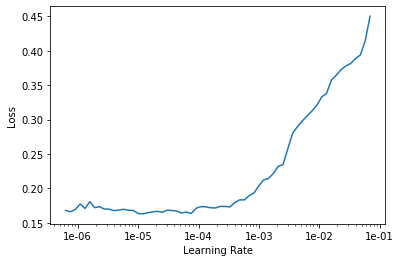

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.209199,0.263415,0.122914,00:24
1,0.227036,0.197167,0.088771,00:24
2,0.196709,0.178605,0.075114,00:24
3,0.170807,0.169240,0.072838,00:24
4,0.134307,0.139764,0.056904,00:24


In [20]:
learn.save('stage-2-rn34')

Should I add iterative resizing? Hard to tell if this can get under .103

## Resnet-50 Attempt
Just repeating the process using the resnet 50 model. 

In [21]:
torch.cuda.empty_cache()

In [22]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [23]:
data50 = data = ImageDataBunch.from_folder(path, train="/train", valid_pct=0.2,
                                  ds_tfms=tfms, size=224, bs=bs//2).normalize(imagenet_stats)

In [24]:
learn50 = cnn_learner(data50, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


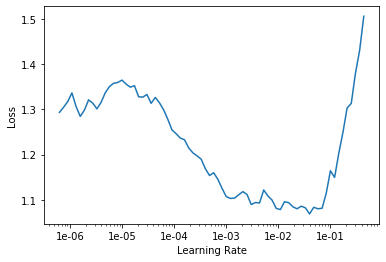

In [25]:
learn50.lr_find()
learn50.recorder.plot()

In [26]:
learn50.fit_one_cycle(7, 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.465583,0.314971,0.154021,00:39
1,0.426994,0.310806,0.146434,00:39
2,0.349555,0.241579,0.111533,00:38
3,0.297719,0.208434,0.097876,00:39
4,0.236370,0.191690,0.084977,00:39
5,0.197571,0.158026,0.070561,00:39


In [27]:
#learn50.save('stage-1-50')

In [28]:
#learn50.load('stage-1-50')

In [29]:
learn50.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


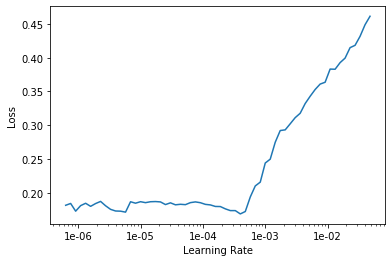

In [30]:
learn50.lr_find()
learn50.recorder.plot()

In [31]:
learn50.fit_one_cycle(5, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.173674,0.155706,0.069044,00:51
1,0.192818,0.151741,0.066768,00:51
2,0.172655,0.157154,0.072838,00:50
3,0.167100,0.157014,0.066009,00:50
4,0.134743,0.147157,0.066768,00:50


In [32]:
#learn50.save('stage-2-50')

### First results interpretation:
Turns out I can't actually read Cancer screening images, so I'm just going to go for the full training routine, and maybe we'll get someone to look at this later.

In [34]:
interp = ClassificationInterpretation.from_learner(learn50)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

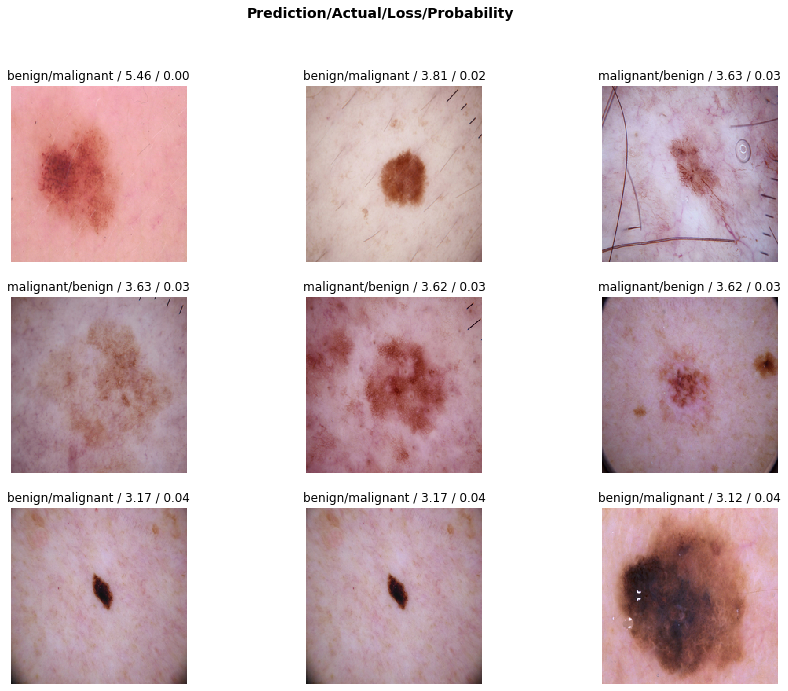

In [35]:
interp.plot_top_losses(9, figsize=(15,11))